# COP27
> Ce notebook sert de marche à suivre pour analyser les données d'une journée de COP

In [74]:
import pandas as pd
import numpy as np
import os
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import datetime

import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2

from quotaclimat.utils.plotly_theme import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
%%html
<style type="text/css">
@import url('http://fonts.googleapis.com/css?family=Poppins');
</style>

# Récupération et préparation des données

## Récupérer et préparer les données de la journée
Choisissez bien le bon fichier

In [76]:
from quotaclimat.data_processing.read_format_deduplicate import read_and_format_one
from quotaclimat.data_processing.read_format_deduplicate import read_and_format_all_data_dump
from quotaclimat.data_processing.read_format_deduplicate import deduplicate_extracts

In [78]:
os.listdir("../data/cop27/0611")

['20221107_20221106_20221106_all_COP27.xlsx',
 '20221107_20221106_20221106_all_écologie.xlsx']

In [79]:
path = "../data/cop27/0611/20221107_20221106_20221106_all_COP27.xlsx"

In [137]:
data = read_and_format_one(path_file = path,path_channels=None)
data.shape

(1518, 14)

## Filtrer sur les 50 chaînes TV et Radio avec le plus d'audience

In [149]:
top_audiences = pd.read_excel("../data/channels.xlsx",sheet_name = "top_audiences")
top_audiences["channel_id"] = top_audiences["channel_name"] + "_" + top_audiences["media"]
top_channels_tv = top_audiences.query("media=='TV'")["channel_name"].tolist()
top_channels_radio = top_audiences.query("media=='Radio'")["channel_name"].tolist()

In [150]:
data["channel_id"] = data["channel_name"] + "_" + data["media"]

In [151]:
data = data.merge(top_audiences[["channel_id"]],on = ["channel_id"],how = "inner")

In [152]:
data.shape

(656, 15)

##### Nombre de chaînes TV ou Radio dans l'échantillon
Vérifier combien de chaînes sur les 50 parlent du sujet 

In [153]:
data.drop_duplicates(subset = ["channel_name"]).groupby(["media"])["channel_name"].count()

media
Radio    10
TV       10
Name: channel_name, dtype: int64

## Filtrer dans les horaires d'antenne entre 6h et minuit

In [154]:
from quotaclimat.data_analytics.exploration import filter_data_between_hours

In [155]:
data = filter_data_between_hours(data,"06:00","24:00")

In [156]:
data.shape

(656, 15)

# Préparation des analyses

In [170]:
from quotaclimat.utils.channels import TOP_25_CHANNELS,TOP_CHANNELS_TV,TOP_CHANNELS_TV_8
from quotaclimat.data_analytics.exploration import show_mentions_by_channel
from quotaclimat.data_analytics.exploration import show_mentions_by_time_of_the_day
from quotaclimat.data_analytics.exploration import show_mentions_over_time
from quotaclimat.data_analytics.exploration import show_mentions_treemap
from quotaclimat.data_analytics.exploration import show_piechart_split_tv_radio

## Analyse 1 - volume médiatique total sur les 50 chaînes

In [171]:
# Multiplier = n_mentions * 2 min / (n_channels * 60 minutes * 18h * n_days)
n_days = 1
n_channels = 25 #TV and Radio

media_time = data.groupby(["media"]).agg({"count":"sum","channel_name":"nunique"})
media_time["n_channels"] = 25
media_time = media_time.append(pd.DataFrame(media_time.sum(axis = 0).rename("Total")).T)
media_time["media_time"] = media_time["count"] * 2
media_time["total_time"] = media_time["n_channels"] * n_days * 18 * 60
media_time["media_part"] = media_time["media_time"] / media_time["total_time"]

media_time

,count,channel_name,n_channels,media_time,total_time,media_part
Radio,330,10,25,660,27000,0.024444
TV,326,10,25,652,27000,0.024148
Total,656,20,50,1312,54000,0.024296


In [172]:
fig = px.bar(media_time.drop("Total").reset_index(),x = "index",y = "media_part",height = 400,text_auto = ".1%")
fig.update_layout(yaxis_tickformat='0%',
                  title = "Volume médiatique total sur les 50 chaînes TV et Radio",
                  font_family="Poppins",yaxis_title="% du volume médiatique",xaxis_title = "")
fig.update_traces(marker_color=["#f49182",'#e6381b'])
fig

## Analyse 1bis - Volume médiatique total sur les top 10 chaînes TV et Radio

In [173]:
# Multiplier = n_mentions * 2 min / (n_channels * 60 minutes * 18h * n_days)
n_days = 1
n_channels = 25 #TV and Radio

data_top10 = data.loc[(data["channel_name"].isin(top_channels_tv[:10])) | (data["channel_name"].isin(top_channels_radio[:10]))]

media_time = data_top10.groupby(["media"]).agg({"count":"sum","channel_name":"nunique"})
media_time["n_channels"] = 10
media_time = media_time.append(pd.DataFrame(media_time.sum(axis = 0).rename("Total")).T)
media_time["media_time"] = media_time["count"] * 2
media_time["total_time"] = media_time["n_channels"] * n_days * 18 * 60
media_time["media_part"] = media_time["media_time"] / media_time["total_time"]

media_time

,count,channel_name,n_channels,media_time,total_time,media_part
Radio,311,7,10,622,10800,0.057593
TV,29,5,10,58,10800,0.005370
Total,340,12,20,680,21600,0.031481


In [174]:
fig = px.bar(media_time.drop("Total").reset_index(),x = "index",y = "media_part",height = 400,text_auto = ".1%")
fig.update_layout(yaxis_tickformat='0%',
                  title = "Volume médiatique total sur les 10 premières chaînes TV et Radio",
                  font_family="Poppins",yaxis_title="% du volume médiatique",xaxis_title = "")
fig.update_traces(marker_color=["#f49182",'#e6381b'])
fig

## Analyse 2 - TOP 3 TV et Radio

In [175]:
# Multiplier for one channel = n_mentions * 2 min / (60 minutes * 18h * n_days)
multiplier = 2 / (1 * 60 * 18 * 1)

fig = show_mentions_by_channel(data,list_of_channels=top_channels_tv,n = 3,
                               method = multiplier,height = 400,text_auto = ".1%")
fig.update_layout(yaxis_tickformat='0%',
                  title = "Podium TV",
                  font_family="Poppins",yaxis_title="% du volume médiatique",xaxis_title = "")
fig.update_traces(marker_color='#e6381b')
fig

In [176]:
# Multiplier for one channel = n_mentions * 2 min / (60 minutes * 18h * n_days)
multiplier = 2 / (1 * 60 * 18 * 1)

fig = show_mentions_by_channel(data,list_of_channels=top_channels_radio,n = 3,
                               method = multiplier,height = 400,text_auto = ".1%")

fig.update_layout(yaxis_tickformat='0%',
                  title = "Podium Radio",
                  font_family="Poppins",yaxis_title="% du volume médiatique",xaxis_title = "")
fig.update_traces(marker_color='#f49182')
fig

## Analyse 3 - Classement complet TV et Radio

In [177]:
# Multiplier for one channel = n_mentions * 2 min / (60 minutes * 18h * n_days)
multiplier = 2 / (1 * 60 * 18 * 1)

fig = show_mentions_by_channel(data,list_of_channels=top_channels_tv,n = 25,split="keyword",
                               method = multiplier,height = 400,text_auto = ".1%",
                               color_discrete_sequence = SEQUENCE)
fig.update_layout(yaxis_tickformat='0%',font_family="Poppins",yaxis_title="% du volume médiatique",title = "Classement TV")
fig.update_traces(marker_color='#e6381b')
fig.show()

# Multiplier for one channel = n_mentions * 2 min / (60 minutes * 18h * n_days)
multiplier = 2 / (1 * 60 * 18 * 1)

fig = show_mentions_by_channel(data,list_of_channels=top_channels_radio,n = 25,split = "keyword",
                               method = multiplier,height = 400,text_auto = ".1%",
                               color_discrete_sequence = SEQUENCE
                              )
fig.update_layout(yaxis_tickformat='0%',font_family="Poppins",yaxis_title="% du volume médiatique",title = "Classement Radio")
fig.update_traces(marker_color='#f49182')
fig.show()

# Autres sujets écologiques

In [146]:
data_total = read_and_format_all_data_dump(path_folder = "../data/cop27/0611/",path_channel_metadata=None)
data_total["channel_id"] = data_total["channel_name"] + "_" + data_total["media"]
data_total = data_total.merge(top_audiences[["channel_id"]],on = ["channel_id"],how = "inner")
data_total = filter_data_between_hours(data_total,"06:00","24:00")

data_total.shape

(1162, 16)

## Analyse 1

In [164]:
# Multiplier = n_mentions * 2 min / (n_channels * 60 minutes * 18h * n_days)
n_days = 1
n_channels = 25 #TV and Radio

media_time = data_total.groupby(["media"]).agg({"count":"sum","channel_name":"nunique"})
media_time["n_channels"] = 25
media_time = media_time.append(pd.DataFrame(media_time.sum(axis = 0).rename("Total")).T)
media_time["media_time"] = media_time["count"] * 2
media_time["total_time"] = media_time["n_channels"] * n_days * 18 * 60
media_time["media_part"] = media_time["media_time"] / media_time["total_time"]

fig = px.bar(media_time.drop("Total").reset_index(),x = "index",y = "media_part",height = 400,text_auto = ".1%")
fig.update_layout(yaxis_tickformat='0%',
                  title = "Volume médiatique total sur les 50 chaînes TV et Radio",
                  font_family="Poppins",yaxis_title="% du volume médiatique",xaxis_title = "")
fig.update_traces(marker_color=["#f49182",'#e6381b'])
fig.show()

# Multiplier = n_mentions * 2 min / (n_channels * 60 minutes * 18h * n_days)
n_days = 1
n_channels = 25 #TV and Radio

data_top10 = data_total.loc[(data_total["channel_name"].isin(top_channels_tv[:10])) | (data_total["channel_name"].isin(top_channels_radio[:10]))]

media_time = data_total.groupby(["media"]).agg({"count":"sum","channel_name":"nunique"})
media_time["n_channels"] = 10
media_time = media_time.append(pd.DataFrame(media_time.sum(axis = 0).rename("Total")).T)
media_time["media_time"] = media_time["count"] * 2
media_time["total_time"] = media_time["n_channels"] * n_days * 18 * 60
media_time["media_part"] = media_time["media_time"] / media_time["total_time"]

fig = px.bar(media_time.drop("Total").reset_index(),x = "index",y = "media_part",height = 400,text_auto = ".1%")
fig.update_layout(yaxis_tickformat='0%',
                  title = "Volume médiatique total sur les 10 premières chaînes TV et Radio",
                  font_family="Poppins",yaxis_title="% du volume médiatique",xaxis_title = "")
fig.update_traces(marker_color=["#f49182",'#e6381b'])
fig.show()

## Analyse 2

In [165]:
# Multiplier for one channel = n_mentions * 2 min / (60 minutes * 18h * n_days)
multiplier = 2 / (1 * 60 * 18 * 1)

fig = show_mentions_by_channel(data_total,list_of_channels=top_channels_tv,n = 3,
                               method = multiplier,height = 400,text_auto = ".1%")
fig.update_layout(yaxis_tickformat='0%',
                  title = "Podium TV",
                  font_family="Poppins",yaxis_title="% du volume médiatique",xaxis_title = "")
fig.update_traces(marker_color='#e6381b')
fig.show()

# Multiplier for one channel = n_mentions * 2 min / (60 minutes * 18h * n_days)
multiplier = 2 / (1 * 60 * 18 * 1)

fig = show_mentions_by_channel(data_total,list_of_channels=top_channels_radio,n = 3,
                               method = multiplier,height = 400,text_auto = ".1%")

fig.update_layout(yaxis_tickformat='0%',
                  title = "Podium Radio",
                  font_family="Poppins",yaxis_title="% du volume médiatique",xaxis_title = "")
fig.update_traces(marker_color='#f49182')
fig

## Analyse 3

In [182]:
DISCRETE_MAP = {
    "COP27":"#cb181d",
    "écologie":"#2171b5",
}

# Multiplier for one channel = n_mentions * 2 min / (60 minutes * 18h * n_days)
multiplier = 2 / (1 * 60 * 18 * 1)

fig = show_mentions_by_channel(data_total,list_of_channels=top_channels_tv,n = 25,split="keyword",
                               method = multiplier,height = 400,text_auto = ".1%",
                               color_discrete_map = DISCRETE_MAP,
                              )
fig.update_layout(yaxis_tickformat='0%',font_family="Poppins",yaxis_title="% du volume médiatique",title = "Classement TV")
# fig.update_traces(marker_color='#e6381b')
fig.show()

# Multiplier for one channel = n_mentions * 2 min / (60 minutes * 18h * n_days)
multiplier = 2 / (1 * 60 * 18 * 1)

fig = show_mentions_by_channel(data_total,list_of_channels=top_channels_radio,n = 25,split = "keyword",
                               method = multiplier,height = 400,text_auto = ".1%",
                               color_discrete_map = DISCRETE_MAP
                              )
fig.update_layout(yaxis_tickformat='0%',font_family="Poppins",yaxis_title="% du volume médiatique",title = "Classement Radio")
# fig.update_traces(marker_color='#f49182')
fig.show()

In [195]:
show_mentions_by_time_of_the_day(
    data_total.query("channel_name=='France 5'"),
    split = "keyword",freq = "1H",method = "minutes",color_discrete_map = DISCRETE_MAP,
    height = 300
)

# Analyse des sujets mentionnés

In [199]:
from quotaclimat.data_processing.keyword_tool import KeywordsTool

kwt = KeywordsTool(case_sensitive=False,lowercase = True)

kwt.load_from_airtable(airtable_table_name="COP27",keyword_col = "name",variants_col=["alternatives_mediatree","alternatives"])

In [223]:
counts_total = kwt.count_keywords_on_corpus(data["text"],as_melted = True)
counts_total = counts_total.query("name!='Pays'")

  0%|          | 0/656 [00:00<?, ?it/s]

In [224]:
px.treemap(
    counts_total.groupby(["name","category"])["count"].sum().reset_index().query("name!='Pays'"),
    path = ["category","name"],
    values = "count",
    color_discrete_sequence = WARMING_STRIPES_SEQUENCE
)

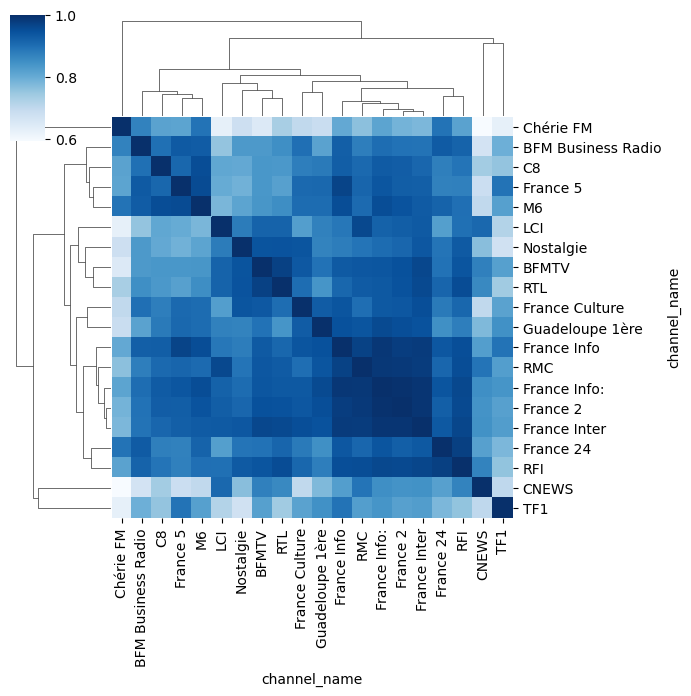

In [261]:
import seaborn as sns
count_pivot = count_by_channel.pivot(index = "channel_name",columns = "category",values = "count").fillna(0.0)
count_pivot = count_pivot.divide(count_pivot.sum(axis = 1),axis = 0)

fig = sns.clustermap(count_pivot.T.corr(),cmap = "Blues",figsize = (7,7))
plt.show()

In [260]:
count_by_channel = (counts_total.merge(data.reset_index()[["index","channel_name"]].rename(columns = {"index":"text_id"}),on = "text_id")
     .groupby(["channel_name","category"],as_index = False).agg({"count":"sum"}))

px.area(
    count_by_channel,x = "channel_name",y = "count",color = "category",groupnorm = "fraction",
    category_orders = {"channel_name":count_pivot.T.columns[fig.dendrogram_col.reordered_ind].tolist()},
    color_discrete_sequence=WARMING_STRIPES_SEQUENCE)